In [1]:
%load_ext autoreload
%autoreload 2
import parmap
import pandas as pd
from tqdm import tqdm,tqdm_notebook
from utils.marking_similars import *
from utils.preprocess import *
from utils.emoji_extract import *
from utils.visualisation import latex_emoji_communities
import matplotlib.pyplot as plt

import empath
import seaborn as sns
from empath import Empath
import networkx as nx
import matplotlib
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu



emoji_stop=['☝','✌', '▪','🏼','🏻','🏿','🏾','🏽','➖','🔽','🇴','🇧','⚜','☘', '☕', '♦','▪','‼','♻','🇪','🇺','🇮', '🇳','🇲', '🇷', '🇸', '🇦', '🇵', '🇰', '🇨']

In [2]:
parent_path='Data/'

import json
with open(parent_path+'fear_speech_data.json', 'r') as fp:
    fear_speech_data=json.load(fp)

In [3]:
fear_speech_data['0']

{'message_text': '*प्रशासक समिति*✊🚩  ●●●●●●●●●●● ● ● ● 😎🚩 *आंतकवादी संगठनों का💣🔪 इस्लामिक नाम और उनका इस्लाम.....* *धर्म से जुड़ा हुआ अर्थ...* 🐖🐖🐖 *1.लश्करे तैयबा-फरिश्तो की सेना* *2.अल कायदा-अल्लाह का कायदा...* *3.जेश ए मोहम्द-मोहम्मद साहेब का दल...* *4.तहरिक ए तालिबान-पवित्र योद्धाओ का दल...* *5.हिजबुल मुजादिन-इस्लामी बलिदानियो का समूह...* *6.बोको हराम -पैगम्बर मुहम्मद की शिक्षा को फैलाने के लिए प्रतिबद्ध..* *सभी मुस्लमान अज्ञानि अल्लाह की बताई हुई रूहानी किताब क़ुरआन की बताई राह* *(पूरी दुनिया को इस्लाम बनाना)पर ही चल रहे है कोई ज्यादा बच👨\u200d👨\u200d👦* *पैदा करके तो कोई लव जिहाद👫 करके तो कोई काफ़िर(गेर मुसलमान)को मारकर..* *धरती पर आंतक🔫💣💣💣🔫फेला रहे है\ufeff।।* 😡😡😡😎😡😡😡  *जय सनातन धर्म की*🚩🚩🚩  🙏🚩🇮🇳🔱🏹🐚🕉',
 'translated_text': '* Administrator ✊ 🚩   Committee * ● ●●●●●●●●●● 🚩  😎  ● ● ● नाम 🔪  💣  * Islamic name of terrorist organizations and their meaning 🐖  🐖  🐖  in Islam… .. * Religion… * ... 1. * 1. Army of Lashkar-e-Taiba-Farishto * * 2. Al Qaeda-Qaeda of Allah ... * * 3. Team of Jesh-

In [4]:
text_tuples=[]

for key in fear_speech_data.keys():
    element = fear_speech_data[key]
    
    count_fearspeech=element['annotation_list'].count('Fear speech')
    count_normal=element['annotation_list'].count('Normal')
    
    if(count_fearspeech>count_normal):
        one_fear_speech=1
    else:
        one_fear_speech=0
    text_tuples.append([element['message_text'],element['translated_text'],one_fear_speech])
    
annotated_df = pd.DataFrame(text_tuples,columns=['message_text','translated','one_fear_speech'])


In [5]:
len(annotated_df)

4782

In [6]:
lexicon = Empath()
dict_map={0:'non fear speech',1:'fear speech'}

def get_empath_categories(df,normalize=False): 
    tuples=[]
    for index,row in tqdm(df.iterrows(),total=len(df)):
        dict_lexicon=lexicon.analyze(row['translated'], normalize=normalize)
        try:
            temp=dict_lexicon.values()
        except AttributeError:
            dict_lexicon=lexicon.analyze("sample text", normalize=normalize)
        temp=list(dict_lexicon.values())+[index,dict_map[row['one_fear_speech']]]
        tuples.append(temp)
    df_empath=pd.DataFrame(tuples,columns=list(dict_lexicon.keys())+['org_index','label'])
    
    
    print(len(df),len(df_empath))
    df=df.reset_index(drop=True)
    #df_with_empath=pd.concat([df,df_empath],axis=1)
    return df_empath


In [7]:
annotated_df_empath=get_empath_categories(annotated_df,normalize=True)
annotated_df_empath = pd.melt(annotated_df_empath,id_vars="label",var_name="category", value_name="normalized_value")
annotated_df_empath=annotated_df_empath[annotated_df_empath['category']!='org_index']
annotated_df_empath.head()

100%|██████████| 4782/4782 [01:30<00:00, 52.88it/s]


4782 4782


,label,category,normalized_value
0,fear speech,help,0.000000
1,non fear speech,help,0.000000
2,fear speech,help,0.000000
3,non fear speech,help,0.000000
4,non fear speech,help,0.008787


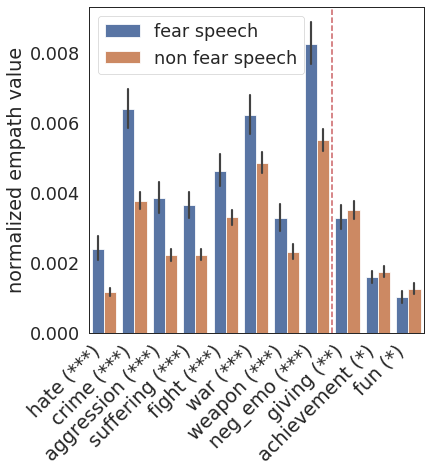

In [8]:
categories=["hate", "crime", "aggression", "suffering", "fight", "war", "weapon","negative_emotion","giving", "achievement", "fun"]

matplotlib.rcParams['figure.figsize'] = (6,6)

sns.set(context='paper',style='white',font_scale=1.5)

temp=annotated_df_empath[annotated_df_empath['category'].isin(categories)]
font = {
    'weight' : 'normal',
    'size'   : 11}

sns.set(context='paper',style='white',font_scale=2.0)

g = sns.barplot(x="category", y="normalized_value",hue="label",order=categories,data=temp)
#g=add_values(g,df_admin,15,order_list)
#plt.ylabel('number of groups as admin')
g.set_xticklabels(
        g.get_xticklabels(), 
        rotation=45, 
        horizontalalignment='right',
        fontweight='normal',
        fontsize='medium'

    )

xlist_label=[]

list_p_vals=[]

for cat in categories:
    temp=annotated_df_empath[annotated_df_empath['category']==cat]
    treatment=np.array(temp[temp['label']=='fear speech'].normalized_value)
    control=np.array(temp[temp['label']=='non fear speech'].normalized_value)
    seed(2)
    # generate two independent samples
    # compare samples
    stat, p = mannwhitneyu(treatment, control)
    list_p_vals.append(p)
    if(cat == 'negative_emotion'):
        cat='neg_emo'
    
#     if(p<=0.00001):
#         cat=cat+" ****"
    if(p<=0.0001):
        cat=cat+" (***)"
    elif(p<=0.001):
        cat=cat+" (**)"
    elif(p<0.01):
        cat=cat+" (*)"
   
        
    xlist_label.append(cat)

    
    

plt.axvline(7.5, linestyle='--',alpha=0.9, color='r',linewidth=1.5)
lt.xticks(ticks=range(0,len(categories)),labels=xlist_label)
plt.xlabel("")
plt.ylabel("normalized empath value")
plt.legend()
plt.show()
#plt.savefig('../Fear_speech_results/empath.pdf',bbox_inches='tight',dpi=400)

In [11]:
from multipy.fwer import sidak
significant_pvals = sidak(list_p_vals, alpha=0.05)

In [14]:
#Correcting significance using sidak correction to take into consideration family wise error rate
for i in range(len(significant_pvals)):
    if(significant_pvals[i]==False):
        print('The category \"'+categories[i]+'\" is not significant')

The category "fun" is not significant


In [15]:
edges={}
emoji_dict={}
emoji_dict_count={}
emoji_dict_reverse={}
window=5


count=0

count_at_least_one=0

for index,row in tqdm_notebook(annotated_df[annotated_df['one_fear_speech']==1].iterrows(),total=len(annotated_df[annotated_df['one_fear_speech']==1])):
    emojis_with_index=extract_emojis_index(row['message_text'])
    
    if(len(emojis_with_index)!=0):
        count_at_least_one+=1
    
    for ele in emojis_with_index:
        try:
            emoji_dict_count[ele[1]]+=1
        except KeyError:
            emoji_dict_count[ele[1]]=1
    
    
    for i in range(len(emojis_with_index)):
        ele1=emojis_with_index[i]
        for j in range(i,len(emojis_with_index)):
            ele2=emojis_with_index[j]
            
            try:
                temp1=emoji_dict[ele1[1]]
            except:
                count+=1
                emoji_dict[ele1[1]]=count
                emoji_dict_reverse[count]=ele1[1]
                temp1=count
            
            try:
                temp2=emoji_dict[ele2[1]]
            except:
                count+=1
                emoji_dict[ele2[1]]=count
                emoji_dict_reverse[count]=ele2[1]
                temp2=count
            
            if(temp1<temp2):
                key_adj=str(temp1)+'--'+str(temp2)
            elif(temp2<temp1):
                key_adj=str(temp2)+'--'+str(temp1)
            else:  
                continue
            try:
#                 edges[key_adj][0]+=abs(ele1[0]-ele2[0])
#                 edges[key_adj][1]+=1
                if(abs(ele1[0]-ele2[0]) <window):
                    edges[key_adj]+=1


            except KeyError:
#                 edges[key_adj]=[abs(ele1[0]-ele2[0]),1]
                 if(abs(ele1[0]-ele2[0])<window):
                    
                    edges[key_adj]=1
            

/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [19]:
print("Propotion of messages with atleast one emoji out of total:-",count_at_least_one/len(annotated_df[annotated_df['one_fear_speech']==1]))

Propotion of messages with atleast one emoji out of total:- 0.5192644483362522


In [20]:
edge_list=[]

for key in edges.keys():
    ele1=int(key.split('--')[0])
    ele2=int(key.split('--')[1])
    if(emoji_dict_count[emoji_dict_reverse[ele1]]<10 or emoji_dict_count[emoji_dict_reverse[ele2]]<10 or emoji_dict_reverse[ele1] in emoji_stop or emoji_dict_reverse[ele2] in emoji_stop):
        continue
        
    avg_distance= edges[key]/(emoji_dict_count[emoji_dict_reverse[ele1]]*emoji_dict_count[emoji_dict_reverse[ele2]])
    edge_list.append([ele1,ele2,avg_distance])

In [21]:
import json
with open("Networks/emoji_dict.json", 'w') as fp:
    json.dump(emoji_dict, fp,ensure_ascii=False)

In [22]:
G = nx.Graph()
G.add_weighted_edges_from(edge_list)

In [23]:
nx.write_weighted_edgelist(G, "Networks/network_emoji_98.edgelist.gz")

### Load precomputed emoji network

In [24]:
import json
with open("Networks/emoji_dict.json", 'r') as fp:
    emoji_dict=json.load(fp)
emoji_dict_reverse = {v: k for k, v in emoji_dict.items()}

G=nx.read_weighted_edgelist("Networks/network_emoji_98.edgelist.gz")
    

In [25]:
import community as community_louvain
import networkx as nx
partion = community_louvain.best_partition(G)

In [26]:
partition_emoji={}
for key in partion:
    emoji=emoji_dict_reverse[int(key)]
    try:
        partition_emoji[partion[key]].append(emoji)
    except KeyError:
        partition_emoji[partion[key]]=[emoji]

In [27]:
for key in partition_emoji:
    print(partition_emoji[key])

['✊', '🚩', '🏹', '👊', '⛳', '🙏', '🤝', '🔱', '🕉', '🌞', '🍁', '🌷', '😊', '🐚', '🔥', '🌹', '🗣', '❗', '〰', '✅', '👆', '😢', '🌼', '💐', '🐆', '👍', '⏺']
['💪', '✔', '😭', '😰', '👏', '😬', '📱', '📲']
['👉', '👿', '😎', '👺', '📗', '✍', '❌', '📌', '⭕', '🐖', '🐷', '🕋', '😈', '❓', '🔰', '🌀']
['😡', '🛑', '✋', '⚫', '🔵', '⬇']
['⚔', '🗡', '🤺', '🦁', '💥', '💣', '🔫', '🐅', '☪']
['😱', '🤔', '👇', '😠', '😏', '👈', '📖', '☹', '😳', '😔', '🌐', '😤', '🔺', '🎀', '➡']
['📚', '✒', '🖌']
['♂', '🤷', '👹', '🧐', '🤫', '💁', '😞', '♀', '🧝', '🤨', '⁉']
['😀', '😁', '😂']


#### Topic analysis



In [29]:
from gensim.models.ldamodel import LdaModel
import gensim
from gensim.models import CoherenceModel


def handler_funtion(data):
    processed_words=list(data['tokenized'])
    dictionary = gensim.corpora.Dictionary(processed_words)
    dictionary.filter_extremes(no_below=3, no_above=0.5, keep_n=50000)
    list_docs=[]
    for index,row in tqdm_notebook(data.iterrows(),total=len(data)):
        list_docs.append(dictionary.doc2bow(row['tokenized']))
    idxtoken={k:v for v,k in dictionary.token2id.items()}
    return dictionary,idxtoken,list_docs



In [33]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

time_filtered_data=annotated_df
params={'remove_numbers':True,'remove_emoji':False,'remove_stop_words':True,'tokenize':True}
token_list=[preprocess_sent(ele,params) for ele in tqdm_notebook(list(time_filtered_data['message_text']),total=len(time_filtered_data))]    
time_filtered_data['tokenized']=token_list
numtopics=10
dictionary,idxtoken,list_docs= handler_funtion(time_filtered_data)
model = LdaModel(list_docs, numtopics, dictionary,random_state=2020,chunksize=100,passes=20)
cm = CoherenceModel(model=model, texts=token_list, coherence='c_v')
coherence = cm.get_coherence()
print("Coherence score",coherence)

/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



Coherence score 0.4513728900160162


In [35]:
model.print_topics()

[(0,
  '0.016*"मुस्लिम" + 0.013*"हिन्दू" + 0.011*"मुसलमान" + 0.009*"बात" + 0.008*"मैं" + 0.008*"देश" + 0.007*"आज" + 0.007*"लोग" + 0.007*"अगर" + 0.007*"जाता"'),
 (1,
  '0.020*"धर्म" + 0.009*"जाता" + 0.007*"“" + 0.007*"कारण" + 0.007*"समाज" + 0.007*"तथा" + 0.006*"नाम" + 0.006*"समय" + 0.006*"इस्लाम" + 0.006*"रूप"'),
 (2,
  '0.015*"〰" + 0.010*"😳" + 0.010*"❓" + 0.009*"🌹" + 0.008*"muslim" + 0.008*"india" + 0.007*"allah" + 0.007*"muslims" + 0.006*"👇" + 0.006*"living"'),
 (3,
  '0.025*"अल्लाह" + 0.011*"तुम" + 0.011*"कुरान" + 0.008*"👇" + 0.008*"इस्लाम" + 0.008*"मुहम्मद" + 0.006*"करो" + 0.005*"मेरे" + 0.005*"ए" + 0.005*"अगर"'),
 (4,
  '0.042*"कश्मीर" + 0.025*"आतंकी" + 0.017*"जम्मू" + 0.016*"खबर" + 0.013*"➖" + 0.012*"🇪" + 0.011*"टाइप" + 0.011*"🇺" + 0.011*"मसूद" + 0.010*"हमले"'),
 (5,
  '0.105*"🚩" + 0.050*"🙏" + 0.036*"🇮" + 0.032*"🇳" + 0.029*"🏻" + 0.026*"👉" + 0.025*"📚" + 0.021*"जय" + 0.021*"👇" + 0.020*"🔱"'),
 (6,
  '0.044*"कांग्रेस" + 0.040*"मोदी" + 0.028*"गांधी" + 0.026*"👤" + 0.021*"देश" + 0.019*"स